In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m
from scipy import interpolate
from scipy.signal import argrelextrema
import scipy
import statistics
import os
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [102]:
#differentiate patient vs control files
fileNames = []
controlFiles = []
patientFiles = []
directory = os.fsencode('/work/PaHaW_spirals')
for file in os.listdir(directory): 
    filename = os.fsdecode(file)
    path = os.path.join('/work/PaHaW_spirals', filename)
    fileNames.append(path)

fileNames.sort()
print (fileNames)

for i in range(len(fileNames)):
    if category[i] == 'PD':
        patientFiles.append(fileNames[i])
    else:
        controlFiles.append(fileNames[i])


['/work/PaHaW_spirals/00001__1_1.csv', '/work/PaHaW_spirals/00002__1_1.csv', '/work/PaHaW_spirals/00003__1_1.csv', '/work/PaHaW_spirals/00004__1_1.csv', '/work/PaHaW_spirals/00005__1_1.csv', '/work/PaHaW_spirals/00006__1_1.csv', '/work/PaHaW_spirals/00007__1_1.csv', '/work/PaHaW_spirals/00008__1_1.csv', '/work/PaHaW_spirals/00009__1_1.csv', '/work/PaHaW_spirals/00010__1_1.csv', '/work/PaHaW_spirals/00013__1_1.csv', '/work/PaHaW_spirals/00014__1_1.csv', '/work/PaHaW_spirals/00015__1_1.csv', '/work/PaHaW_spirals/00016__1_1.csv', '/work/PaHaW_spirals/00017__1_1.csv', '/work/PaHaW_spirals/00018__1_1.csv', '/work/PaHaW_spirals/00019__1_1.csv', '/work/PaHaW_spirals/00020__1_1.csv', '/work/PaHaW_spirals/00022__1_1.csv', '/work/PaHaW_spirals/00023__1_1.csv', '/work/PaHaW_spirals/00024__1_1.csv', '/work/PaHaW_spirals/00025__1_1.csv', '/work/PaHaW_spirals/00026__1_1.csv', '/work/PaHaW_spirals/00027__1_1.csv', '/work/PaHaW_spirals/00028__1_1.csv', '/work/PaHaW_spirals/00029__1_1.csv', '/work/PaHa

In [3]:
# global variables/parameters
n = 5000
smoothing_factor = 5

## Altitude & Azimuth (Pen Angle)

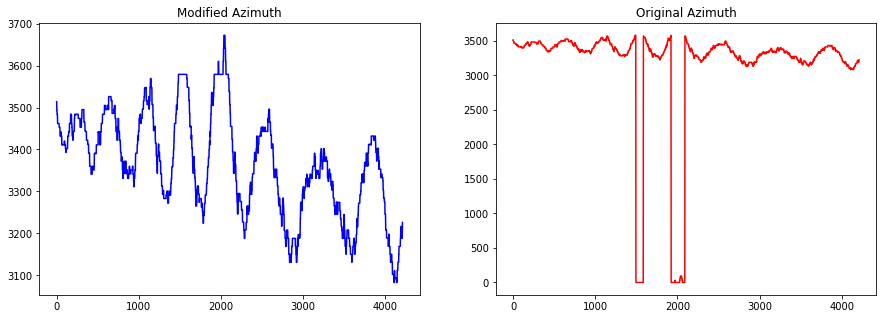

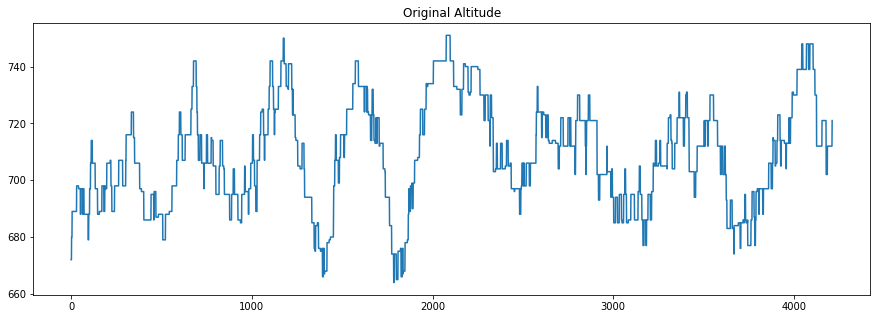

In [4]:
df = pd.read_csv('/work/PaHaW_spirals/00009__1_1.csv', header = None)
azimuth_read = df[4]
maximum = azimuth_read.max()
azimuth = []
# accounts for jumps
threshold = 0.15
if 0 in azimuth_read: 
    for i in azimuth_read: 
        if i/maximum < threshold: 
            i += maximum
        azimuth.append(i)
else: 
    azimuth = azimuth_read
altitude = df[5]

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.title('Modified Azimuth')
plt.plot(azimuth, 'b')
plt.subplot(1, 2, 2)
plt.title('Original Azimuth')
plt.plot(azimuth_read, 'r')

plt.figure(figsize = (15, 5))
plt.title('Original Altitude')
plt.plot(altitude)

## Pressure Regression

Doesn't seem like regression really makes sense given all the different shapes of the pressure curve; these seem like mostly just tremors

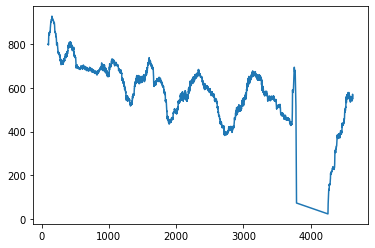

0.5431791195709926
const    757.191703
x1        -0.082024
dtype: float64
264817.788395342


In [129]:
df = pd.read_csv('/work/PaHaW_spirals/00018__1_1.csv', header = None)
pressure = df[df[3] == 1][6]
pressure = pressure[100:len(pressure)-150]
plt.plot(pressure)
plt.show()
model = sm.OLS(pressure, sm.add_constant(np.array(range(len(pressure)))))
results = model.fit()
print(results.rsquared)
print(results.params)
print (sum(abs(results.resid)))

<AxesSubplot:>

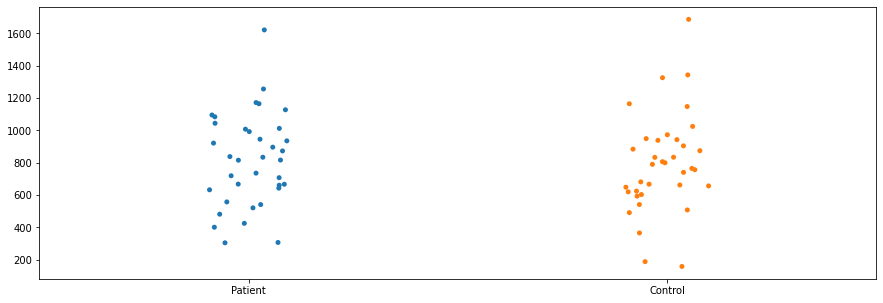

In [135]:
# Pressure Regression Scatterplots (Don't show too much promise at the moment (other than x1 constant))
plt.figure(figsize = (15, 5))
rsquared = []
xlist = []
for filename in patientFiles: 
    df = pd.read_csv(filename, header = None)
    pressure = df[df[3] == 1][6]
    pressure[100:len(pressure)-150]
    model = sm.OLS(pressure, sm.add_constant(np.array(range(len(pressure)))))
    results = model.fit()
    rsquared.append(results.params.const)
    xlist.append('Patient')

for filename in controlFiles: 
    df = pd.read_csv(filename, header = None)
    pressure = df[df[3] == 1][6]
    pressure[100:len(pressure)-150]
    model = sm.OLS(pressure, sm.add_constant(np.array(range(len(pressure)))))
    results = model.fit()
    rsquared.append(results.params.const)
    xlist.append('Control')

sns.stripplot(x = xlist, y = rsquared)

In [6]:
# Double Smoothing (We are not using this)
def extraSmoothCurveFeature(curve, n): 
    t = np.linspace(0, curve.shape[1], n)
    
    sx = interpolate.UnivariateSpline(np.arange(curve.shape[1]-10), curve[0,:-10], k=4)
    sy = interpolate.UnivariateSpline(np.arange(curve.shape[1]-10), curve[1,:-10], k=4)
    pressure_f = interpolate.UnivariateSpline(np.arange(np.shape(df[6])[0]), np.array(df[6]), k=4)
    sx.set_smoothing_factor(2000)
    sy.set_smoothing_factor(2000)

    # velocity functions
    sxdot = sx.derivative()
    sydot = sy.derivative()

    # velocity arrays
    xvel = sxdot(t)
    yvel = sydot(t)

    # smoothed velocity functions
    smoothed_sxdot = interpolate.UnivariateSpline(np.arange(len(xvel)), xvel, k=4)
    smoothed_sydot = interpolate.UnivariateSpline(np.arange(len(yvel)), yvel, k=4)

    xvel1 = smoothed_sxdot(t)
    yvel1 = smoothed_sydot(t)

    # acceleration functions
    sxdotdot = smoothed_sxdot.derivative()
    sydotdot = smoothed_sydot.derivative()
    
    # acceleration arrays
    xaccel = sxdotdot(t)
    yaccel = sydotdot(t)

    # smoothed acceleration functions
    '''smoothed_sxdotdot = interpolate.UnivariateSpline(np.arange(len(xaccel)), xaccel, k = 4)
    smoothed_sydotdot = interpolate.UnivariateSpline(np.arange(len(yaccel)), yaccel, k=4)'''

    # jerk functions 
    sxdotdotdot = sxdotdot.derivative()
    sydotdotdot = sydotdot.derivative()

    # jerk arrays 
    xjerk = sxdotdotdot(t)
    yjerk = sydotdotdot(t)

    velocity = np.sqrt(xvel1**2 + yvel1**2)
    acceleration = np.sqrt(xaccel**2 + yaccel**2)
    jerk = np.sqrt(xjerk**2 + yjerk**2)

    return velocity, acceleration, jerk, pressure_f(t)

In [7]:
#List of healthy patients
lst = list(range(26, 33)) + list(range(39, 42)) + [49, 51, 52] + [57, 61, 62, 66, 67, 69, 70, 71, 72, 73] + [76] + [82, 83, 84, 85, 87, 89, 90, 91, 92, 94, 95, 96, 97]
len(lst)

37

In [8]:
# Reading in the Patient Status
excel = pd.read_excel('corpus_PaHaW.xlsx', engine = 'openpyxl')
# exclude patients 61, 80, 89
category = excel['Disease'].drop([46, 60, 66]).values

[1.0, 1.0, 1.0, 0.9798951048951049, 1.0, 0.9901199717713479, 0.8820444261620732, 1.0, 1.0, 0.8785773826062795, 1.0, 1.0, 0.9092664092664092, 1.0, 1.0, 0.9023674837628326, 0.9223866682204871, 1.0, 0.9086198775317946, 1.0, 0.9829059829059829, 0.9601328903654485, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9404528934861616, 1.0, 1.0, 1.0, 1.0, 0.9964753272910373, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980130570536475, 1.0, 1.0, 1.0, 1.0, 0.931023419955085, 1.0, 1.0, 0.8829787234042553, 0.9502732240437158, 1.0, 1.0, 1.0, 1.0, 0.9744105807935595, 1.0, 1.0, 1.0, 1.0, 0.997016706443914, 0.9821337417049515, 1.0, 0.9568764568764568, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.928521373510862, 1.0]


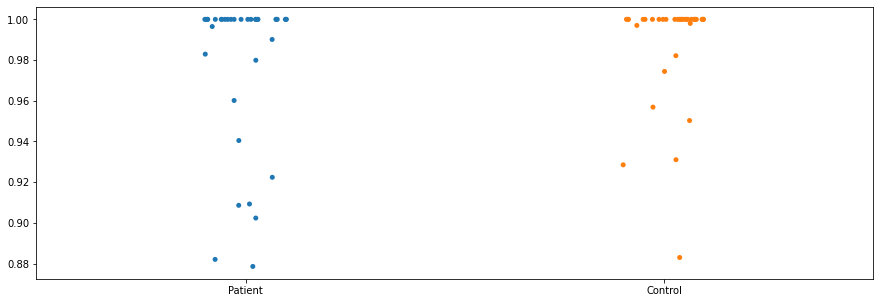

In [ ]:
plt.figure(figsize = (15, 5))
ratio = []
xlist = []
for filename in patientFiles: 
    df = pd.read_csv(filename, header = None)
    '''print(filename)
    print(df[3].value_counts())'''
    off = df[3][df[3]==0]
    on = df[3][df[3]==1]
    ratio.append(len(on)/len(df[3]))
    xlist.append('Patient')

for filename in controlFiles: 
    df = pd.read_csv(filename, header = None)
    '''print(filename)
    print(df[3].value_counts())'''
    off = df[3][df[3]==0]
    on = df[3][df[3]==1]
    ratio.append(len(on)/len(df[3]))
    xlist.append('Control')

sns.stripplot(x = xlist, y = ratio)
print(ratio)

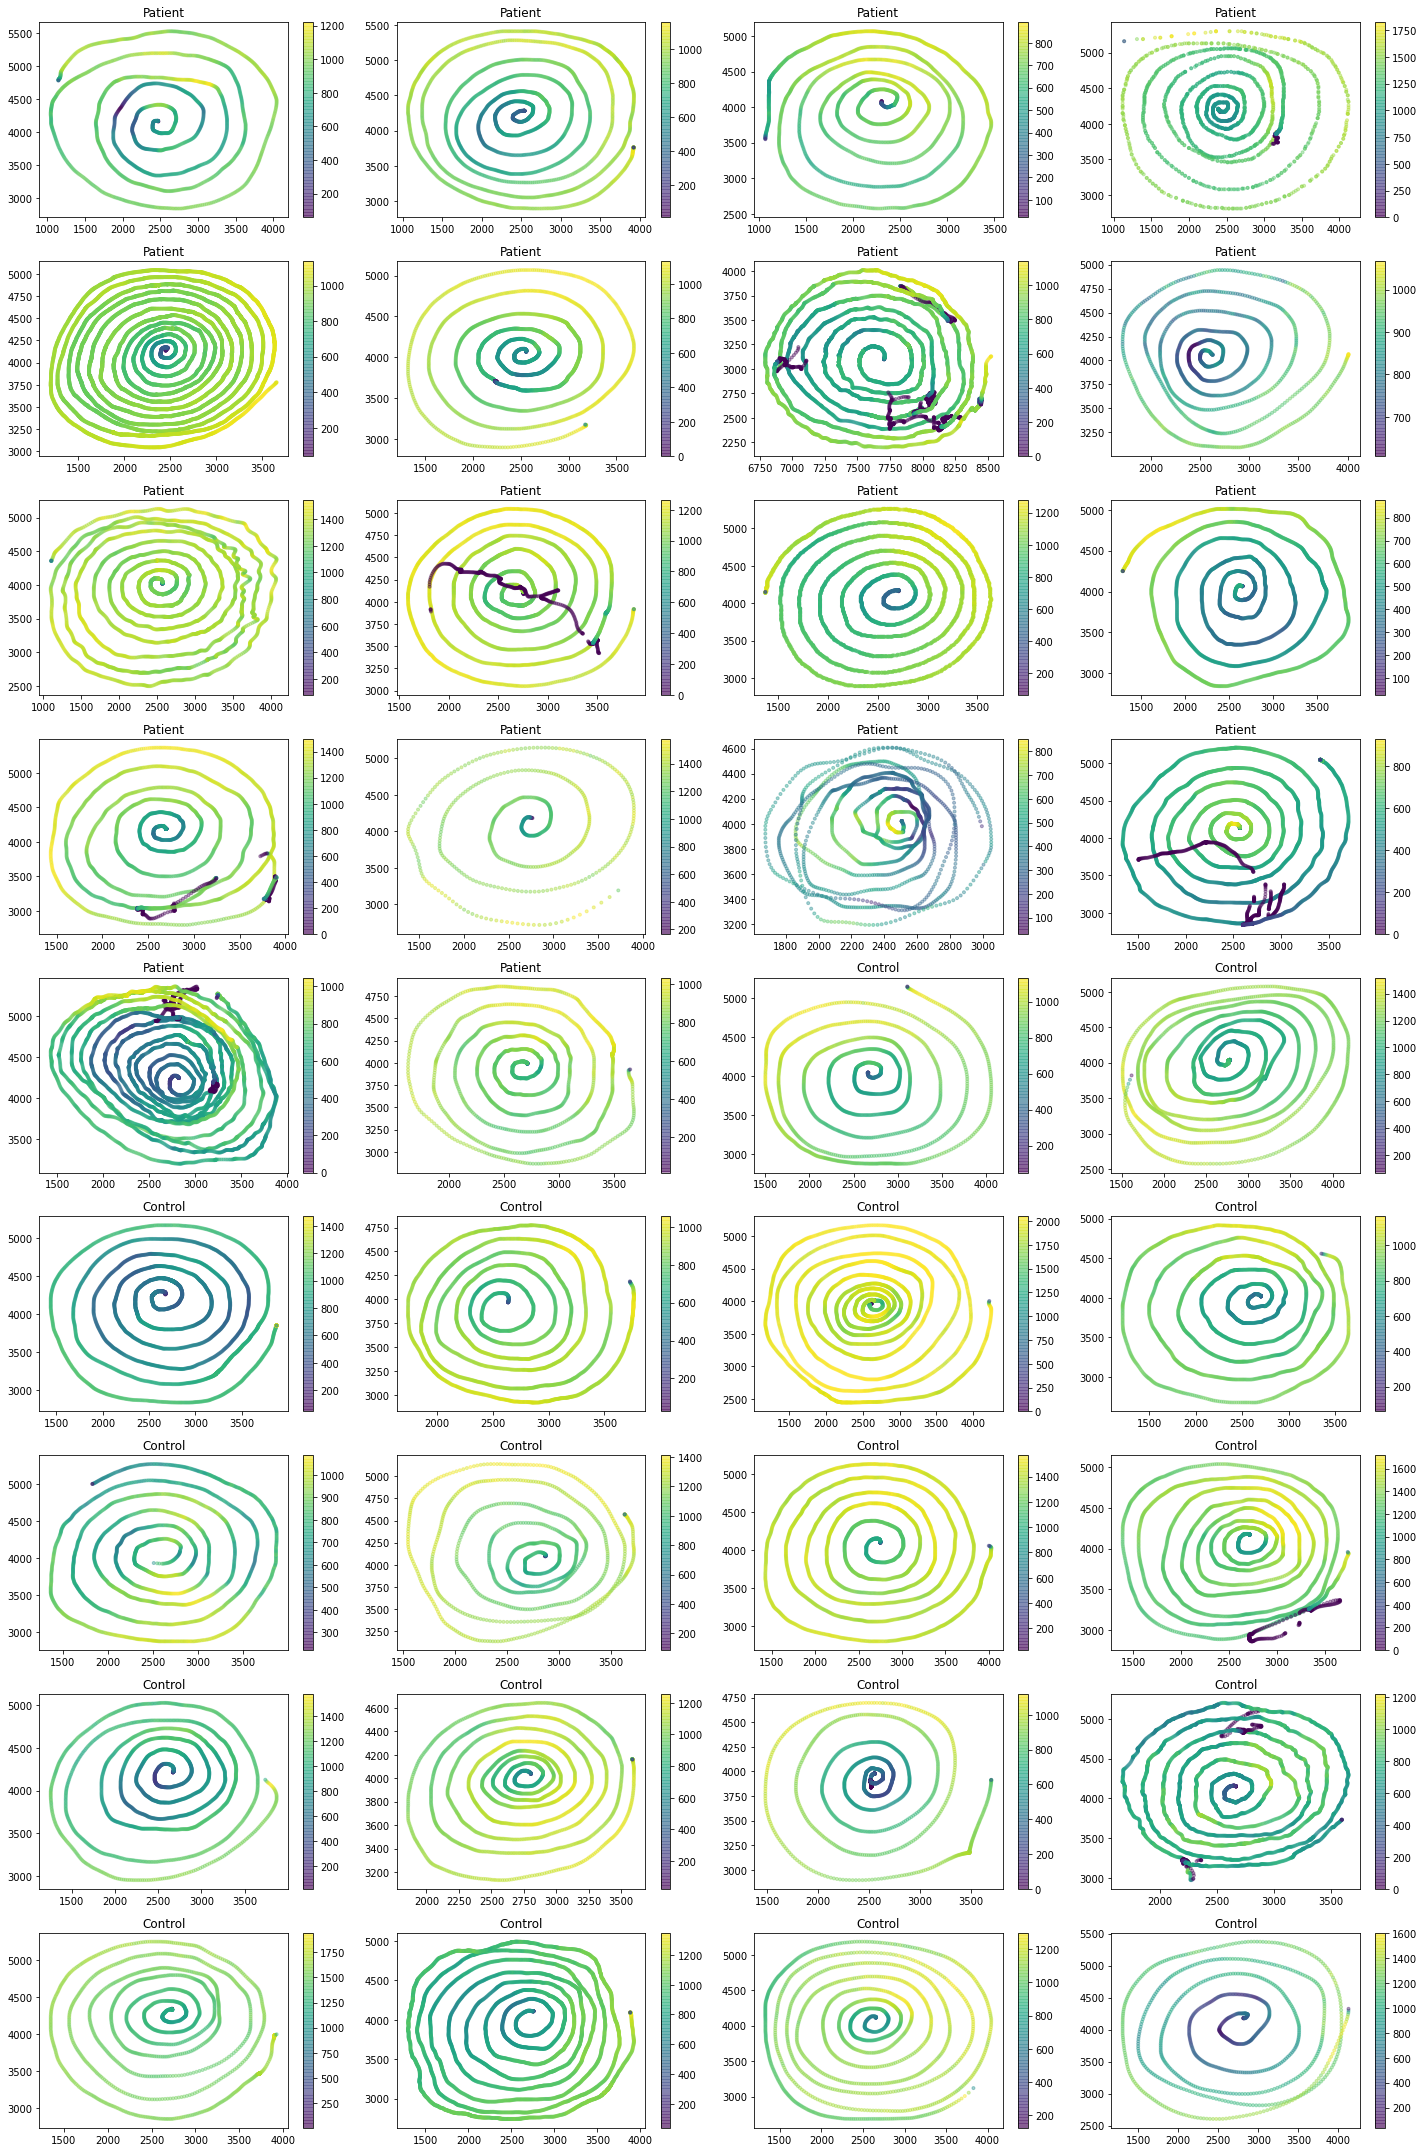

In [10]:
#0    	X coordinate
#1    	Y coordinate
#2    	time stamp
#3    	on/off state
#4    	azimuth
#5    	altitude
#6    	pressure

#Plot of Pressure over the Coordinates
count = 0
plt.figure(figsize = (20, 30), tight_layout = True)
for filename in patientFiles[:18]+controlFiles[:18]: #plot 18 patients and then 18 controls
    df = pd.read_csv(filename, header = None)
    x = df[0]
    y = df[1]
    t = df[2]
    count += 1

    plt.subplot(9, 4, count)
    plt.scatter(x, y, c = df[6], alpha = 0.4, marker = '.')
    if filename in patientFiles:
        plt.title('Patient')
    else:
        plt.title('Control')
    plt.colorbar()
plt.show()
#df

In [12]:
# return (velocity, acceleration, jerk, curvature)
def smoothCurveFeature(curve, n):
    smoothing_factor = len(curve[0,:]) * 50
    t = np.linspace(0, curve.shape[1], n)

    sx = interpolate.UnivariateSpline(np.arange(curve.shape[1]), curve[0,:], k=4)
    sy = interpolate.UnivariateSpline(np.arange(curve.shape[1]), curve[1,:], k=4)
    pressure_f = interpolate.UnivariateSpline(np.arange(np.shape(df[6])[0]), np.array(df[6]), k=4)
    
    sx.set_smoothing_factor(smoothing_factor)
    sy.set_smoothing_factor(smoothing_factor)
    pressure_f.set_smoothing_factor(smoothing_factor)
    
    # velocity based on the splined x and y coordinates
    sxdot = sx.derivative()
    sydot = sy.derivative()
    #xvelArr = sxdot(t)
    #yvelArr = sydot(t)
    
    # splined velocity functions (used to calculate acceleration)
    '''velx_spline = interpolate.UnivariateSpline(np.arange(len(xvelArr)), xvelArr, k=4)
    vely_spline = interpolate.UnivariateSpline(np.arange(len(yvelArr)), yvelArr, k=4)
    velx_spline.set_smoothing_factor(smoothing_factor)
    vely_spline.set_smoothing_factor(smoothing_factor)'''

    # acceleration functions based on the splined velocity x & y functions
    #sxdotdot = velx_spline.derivative()
    #sydotdot = vely_spline.derivative()
    sxdotdot = sxdot.derivative()
    sydotdot = sydot.derivative()

    # splined acceleration functions 
    '''xaccArr = sxdotdot(t)
    yaccArr = sydotdot(t)
    accelx_spline = interpolate.UnivariateSpline(np.arange(len(xaccArr)), xaccArr, k=4)
    accely_spline = interpolate.UnivariateSpline(np.arange(len(yaccArr)), yaccArr, k=4)
    accelx_spline.set_smoothing_factor(smoothing_factor)
    accely_spline.set_smoothing_factor(smoothing_factor)'''

    # jerk based on splined accel x & y functions
    #sxdotdotdot = accelx_spline.derivative()
    #sydotdotdot = accely_spline.derivative()
    sxdotdotdot = sxdotdot.derivative()
    sydotdotdot = sydotdot.derivative()
    #xjerkArr = sxdotdotdot(t)
    #yjerkArr = sydotdotdot(t)

    #jerkx_spline = interpolate.UnivariateSpline(np.arange(len(xjerkArr)), xjerkArr, k=4)
    #jerky_spline = interpolate.UnivariateSpline(np.arange(len(yjerkArr)), yjerkArr, k=4)
    #jerkx_spline.set_smoothing_factor(smoothing_factor)
    #jerky_spline.set_smoothing_factor(smoothing_factor)
    
    '''new_curve = np.zeros((2, n))
    new_curve[0,:] = sx(t)
    new_curve[1,:] = sy(t)'''

    #calculate velocity
    velocity = np.sqrt((sydot(t))**2 + (sxdot(t))**2)
    #velocity_f = interpolate.UnivariateSpline(np.arange(len(velocity)), velocity)
    #velocity_f.set_smoothing_factor(smoothing_factor)

    #calculate acceleration
    acceleration = np.sqrt((sydotdot(t))**2 + (sxdotdot(t))**2)
    #accleration = np.sqrt((velx_spline(t))**2 + (vely_spline(t))**2)
    #acceleration = interpolate.UnivariateSpline(np.arange(len(accel)), accel)
    #acceleration.set_smoothing_factor(smoothing_factor)

    #calculate jerk
    #jerk = np.sqrt((accelx_spline(t))**2 + (accely_spline(t))**2)
    jerk = np.sqrt((sydotdotdot(t))**2 + (sxdotdotdot(t))**2)
    #jerk = interpolate.UnivariateSpline(np.arange(len(jk)), jk)
    #jerk.set_smoothing_factor(smoothing_factor)
    
    # calculate curvature
    curvature = (sxdot(t) * sydotdot(t) - sydot(t) * sxdotdot(t))/(sxdot(t)**2 + sydot(t)**2)**(3/2)

    pressure = pressure_f(t)

    '''# spline fit to curvature
    try: 
        curv_spline = interpolate.UnivariateSpline(np.arange(curve.shape[1]), curvature)
    except: 
        print(len(np.arange(curve.shape[1])), len(curvature))
    curv_spline_eval = curv_spline(t)
    
    curv_dot_spline = curv_spline.derivative()
    curv_dot_eval = curv_dot_spline(t)'''
    
    # new_curve: interpolated/transformed curve, curv_spline_eval: curvature, curv_dot_eval: rate of change of curvature
    return sx(t), sy(t), velocity, acceleration, jerk, curvature, pressure


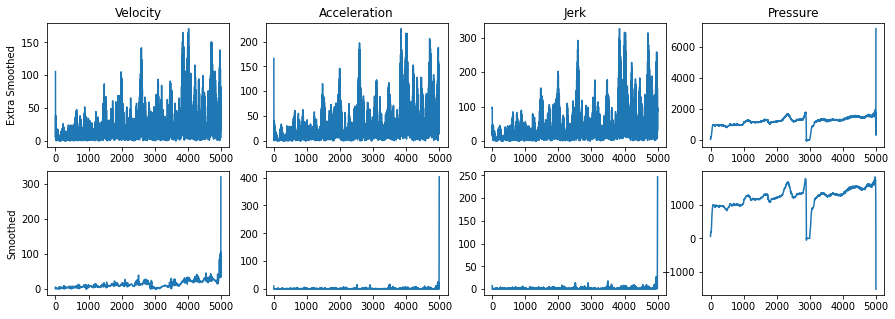

In [13]:
# Comparison of Smoothed and Extra Smoothed
df = pd.read_csv('/work/PaHaW_spirals/00004__1_1.csv', header = None)
x = df[1][:2500]
y = df[0][:2500]
t = df[2]
curve = np.array([x, y])
velocity, acceleration, jerk, pressure = extraSmoothCurveFeature(curve, n)
plt.figure(figsize = (15, 5))
plt.subplot(2, 4, 1)
plt.ylabel("Extra Smoothed")
plt.plot(velocity)
plt.title("Velocity")
plt.subplot(2, 4, 2)
plt.plot(acceleration)
plt.title("Acceleration")
plt.subplot(2, 4, 3)
plt.title("Jerk")
plt.plot(jerk) 
plt.subplot(2, 4, 4)
plt.title("Pressure")
plt.plot(pressure)
_, _, velocity, acceleration, jerk, curvature, pressure = smoothCurveFeature(curve, n)
plt.subplot(2, 4, 5)

plt.plot(velocity)
plt.ylabel("Smoothed")
plt.subplot(2, 4, 6)
plt.plot(acceleration)
plt.subplot(2, 4, 7)
plt.plot(jerk)
plt.subplot(2, 4, 8)
plt.plot(pressure)

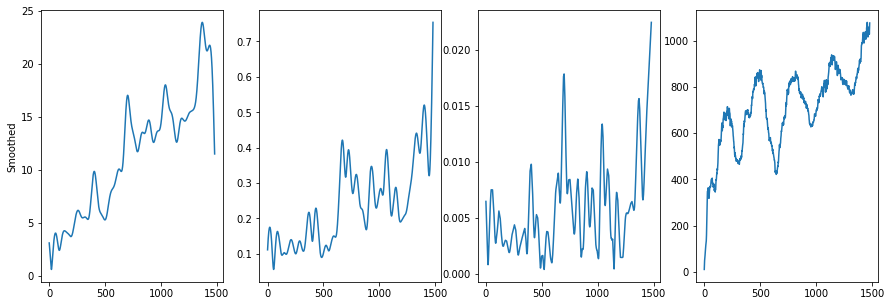

In [14]:
# Plot of Velocity, Acceleration, Jerk, and Pressre for a Singe Patient
df = pd.read_csv('/work/PaHaW_spirals/00002__1_1.csv', header = None)
x = df[df[3]==1][0][:1480]
y = df[df[3]==1][1][:1480]
t = df[df[3]==1][2][:1480]
n = 1480
curve = np.array([x, y])
_, _, velocity, acceleration, jerk, curvature, pressure = smoothCurveFeature(curve, n)
plt.figure(figsize = (15, 5))
plt.subplot(1, 4, 1)
plt.plot(velocity)
plt.ylabel("Smoothed")
plt.subplot(1, 4, 2)
plt.plot(acceleration)
plt.subplot(1, 4, 3)
plt.plot(jerk)
plt.subplot(1, 4, 4)
plt.plot(pressure)

# Curvature Regression

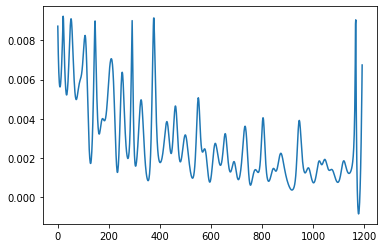

In [159]:
df = pd.read_csv('/work/PaHaW_spirals/00004__1_1.csv', header = None)
x = df[df[3]==1][0][:1480]
y = df[df[3]==1][1][:1480]
t = df[df[3]==1][2][:1480]
n = 1480
curve = np.array([x, y])
_, _, velocity, acceleration, jerk, curvature, pressure = smoothCurveFeature(curve, n)
curvature = curvature[100:len(curvature)-100]
Q1 = np.quantile(curvature, 0.25)
Q3 = np.quantile(curvature, 0.75)
IQR = Q3 - Q1
outliers = (curvature < (Q1 - 1.5 * IQR)) |(curvature > (Q3 + 1.5 * IQR))
curvature = curvature[~outliers]
plt.plot(curvature)

In [15]:
# duration
def duration_calc(timestamps): 
    total_duration = timestamps[len(timestamps) - 1] - timestamps[0]
    return total_duration

# total displacement
def total_displacement_calc(displacement): 
    total_displacement = np.sum(np.array(displacement))
    return total_displacement

In [16]:
# mean velocity
def velocity_mean(velocity): 
    return np.mean(velocity)

# median velocity
def velocity_median(velocity): 
    return np.median(velocity)

# max velocity
def velocity_max(velocity): 
    return np.max(velocity)

# velocity std
def velocity_std(velocity): 
    return np.std(velocity)

# number of inversions in velocity (niv), normalized by total time
def velocity_niv(velocity): 
    maximum = argrelextrema(np.array(velocity), np.greater)  
    minimum = argrelextrema(np.array(velocity), np.less)  
    return (len(maximum[0])+len(minimum[0]))/duration_calc(timestamps)

# normal velocity variability
def velocity_nvv(velocity): 
    sigma_sum = 0
    for i in range(1, len(velocity) - 1): 
        sigma_sum += abs(velocity[i+1] - velocity[i])
    T = duration_calc(timestamps)
    nvv = 1/(T * abs(velocity_mean(velocity))) * sigma_sum
    return nvv

In [17]:
# mean acceleration
def accel_mean(acceleration):
    return np.mean(acceleration)

# max acceleration
def accel_max(acceleration):
    return np.max(acceleration)
    
# median acceleration
def accel_median(acceleration): 
    return np.median(acceleration)

# acceleration std
def accel_std(acceleration):
    return np.std(acceleration)

# number of inversions in acceleration (nia): 
def accel_nia(acceleration):
    maximum = argrelextrema(np.array(acceleration), np.greater)  
    minimum = argrelextrema(np.array(acceleration), np.less)  
    return (len(maximum[0])+len(minimum[0]))/ duration_calc(timestamps)

In [18]:
# mean jerk
def jerk_mean(jerk):
    return np.mean(jerk)

# max jerk
def jerk_max(jerk):
    return np.max(jerk)
    
# median jerk
def jerk_median(jerk): 
    return np.median(jerk)

# jerk std
def jerk_std(jerk):
    return np.std(jerk)

# number of inversions in jerk (nij): 
def jerk_nij(jerk):
    maximum = argrelextrema(np.array(jerk), np.greater)
    minimum = argrelextrema(np.array(jerk), np.less)     
    return (len(maximum[0]) + len(minimum[0]))/ duration_calc(timestamps)

In [19]:
# number of inversions in curvature
def curvature_nic(curvature): 
    maximum = argrelextrema(np.array(curvature), np.greater)  
    minimum = argrelextrema(np.array(curvature), np.less)  
    return (len(maximum[0])+len(minimum[0])) / duration_calc(timestamps)

# true curvature at each point? 

In [20]:
# mean pressure
def pressure_calc():
    return interpolate.UnivariateSpline(np.arange(np.shape(df[6])[0]), np.array(df[6]), k=4)

def pressure_mean(pressure):
    return np.mean(pressure)

# max pressure
def pressure_max(pressure):
    return np.max(pressure)
    
# median pressure
def pressure_median(pressure): 
    return np.median(pressure)

# pressure std
def pressure_std(pressure):
    return np.std(pressure)

# rate of change of pressure inversions
def rip(pressure): 
    maximum = argrelextrema(np.array(pressure), np.greater)  
    minimum = argrelextrema(np.array(pressure), np.less)  
    return (len(maximum[0])+len(minimum[0])) / duration_calc(timestamps)

In [21]:
# Gets the time length of the shortest spiral
import os
min_val = 2000
for file in os.listdir(directory): 
    filename = os.fsdecode(file)
    path = os.path.join('/work/PaHaW_spirals', filename)
    x = df[0]
    df = pd.read_csv(path, header = None)
    if (len(x)) < 2000: 
        min_val = len(x)
print(min_val)

1480


In [ ]:
lenDrawing = 1480
n = 1480
# constructs the Pandas DataFrame for gathering all the features
subject_id = []
mean_vel = []
median_vel = []
max_vel = []
vel_std = []
vel_niv = []
nvv = []
mean_accel = []
max_accel = []
median_accel = []
std_accel = []
nia_accel = []
mean_jerk = []  
max_jerk = []
median_jerk = []
std_jerk = []
nij = []
nic = []
mean_pressure = []
median_pressure = []
max_pressure = []
std_pressure = []
#total_displacement = []
duration = []
rate_of_change_pressure = []

# all the drawings
directory = os.fsencode('/work/PaHaW_spirals')
for file in os.listdir(directory): 
    filename = os.fsdecode(file)
    path = os.path.join('/work/PaHaW_spirals', filename)
    print (filename)
    df = pd.read_csv(path, header = None)
    x = df[df[3]==1][0][:lenDrawing]
    y = df[df[3]==1][1][:lenDrawing]
    t = df[df[3]==1][2][:lenDrawing]
    curve = np.array([x, y])
    _, _, velocity, acceleration, jerk, curvature, pressure = smoothCurveFeature(curve, n)
    timestamps = df[df[3]==1][2][:lenDrawing]

    velocity = velocity[50:len(velocity)]
    acceleration = acceleration[50:len(acceleration)]
    jerk = jerk[50:len(jerk)]
    pressure = pressure[50:len(pressure)]
    
    subject_id.append(filename[:-4])

    mean_vel.append(velocity_mean(velocity))
    median_vel.append(velocity_median(velocity))
    max_vel.append(velocity_max(velocity))
    vel_std.append(velocity_std(velocity))
    vel_niv.append(velocity_niv(velocity))
    nvv.append(velocity_nvv(velocity))

    mean_accel.append(accel_mean(acceleration))
    median_accel.append(accel_median(acceleration))
    max_accel.append(accel_max(acceleration))
    std_accel.append(accel_std(acceleration))
    nia_accel.append(accel_nia(acceleration))

    mean_jerk.append(jerk_mean(jerk))
    median_jerk.append(jerk_median(jerk))
    max_jerk.append(jerk_max(jerk))
    std_jerk.append(jerk_std(jerk))
    nij.append(jerk_nij(jerk))

    nic.append(curvature_nic(curvature))

    duration.append(duration_calc(timestamps))
    #total_displacement.append(total_displacement_calc(displacement))

    mean_pressure.append(pressure_mean(pressure))
    max_pressure.append(pressure_max(pressure))
    median_pressure.append(pressure_median(pressure))
    std_pressure.append(pressure_std(pressure))
    rate_of_change_pressure.append(rip(pressure))

00070__1_1.csv
00096__1_1.csv
00027__1_1.csv
00028__1_1.csv
00060__1_1.csv
00008__1_1.csv
00007__1_1.csv
00040__1_1.csv
00017__1_1.csv
00018__1_1.csv
00067__1_1.csv
00030__1_1.csv
00078__1_1.csv
00077__1_1.csv
00091__1_1.csv
00020__1_1.csv
00048__1_1.csv
00010__1_1.csv
00057__1_1.csv
00051__1_1.csv
00006__1_1.csv
00009__1_1.csv
00041__1_1.csv
00019__1_1.csv
00016__1_1.csv
00098__1_1.csv
00097__1_1.csv
00071__1_1.csv
00029__1_1.csv
00026__1_1.csv
00087__1_1.csv
/shared-libs/python3.7/py/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:279: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
00036__1_1.csv
00039__1_1.csv
00049__1_1.csv
00001__1_1.csv
00069__1_1.csv
00066__1_1.csv
00031__1_1.csv
00090__1_1.csv


In [ ]:
features_df_static = pd.DataFrame({
    'Subject ID': subject_id,
    'Mean Velocity': mean_vel, 'Velocity Std': vel_std, 'Peak Velocity': max_vel, 'NVV': nvv, 'NIV': vel_niv, 
    'Mean Acceleration': mean_accel, 'Acceleration Std': std_accel, 'Peak Acceleration': max_accel, 'NIA': nia_accel, 
    'Mean Jerk': mean_jerk, 'Jerk Std': std_jerk, 'Max Jerk': max_jerk, 'NIJ': nij, 
    'NIC': nic, 
    'Duration': duration, 
    #'Total Displacement': total_displacement, 
    'Mean Pressure': mean_pressure, 'Median Pressure': median_pressure, 'Peak Pressure': max_pressure, 'Pressure Std': std_pressure, 'Rate of Inversion in Pressure': rate_of_change_pressure
    })

features_df_static = features_df_static.sort_values(by = ['Subject ID'], ascending = True)
features_df_static = features_df_static.reset_index(drop=True)

In [ ]:
filename = '5factorlengthData_static_PaHaW_features.csv'
features_df_static.to_csv (filename, index = False, header=True)

In [ ]:
excel = pd.read_excel('corpus_PaHaW.xlsx', engine = 'openpyxl')
# exclude patients 61, 80, 89
category = excel['Disease'].drop([46, 60, 66]).values
features_df_static['Category'] = [i == 'PD' for i in category]
features_df_static

,Subject ID,Mean Velocity,Velocity Std,Peak Velocity,NVV,NIV,Mean Acceleration,Acceleration Std,Peak Acceleration,NIA,...,Max Jerk,NIJ,NIC,Duration,Mean Pressure,Median Pressure,Peak Pressure,Pressure Std,Rate of Inversion in Pressure,Category
0,00001__1_1,14.309278,4.236725,23.754177,0.000636,0.002179,0.284131,0.100270,0.839677,0.003005,...,0.034750,0.006687,0.003306,13310,829.811271,880.876952,1213.075358,186.370459,0.021412,True
1,00002__1_1,11.617773,5.443295,23.909372,0.000360,0.001377,0.239878,0.115321,0.753604,0.001928,...,0.022444,0.002920,0.002094,18151,721.039846,752.894951,1079.056834,158.028077,0.023800,True
2,00003__1_1,13.433291,4.692805,22.034349,0.000448,0.001607,0.305063,0.128690,0.600071,0.002635,...,0.025381,0.004564,0.002892,15558,704.104576,699.735658,868.964643,82.921941,0.021725,True
3,00004__1_1,9.637759,5.083933,23.138526,0.000870,0.002091,0.280377,0.154432,0.746779,0.003319,...,0.056151,0.005001,0.003274,21994,1119.540896,1169.357140,1772.179377,296.408990,0.026325,True
4,00005__1_1,2.566846,0.500363,4.109742,0.000030,0.000097,0.034714,0.009487,0.055256,0.000122,...,0.002399,0.000252,0.000138,123097,757.060588,796.513440,961.186757,138.129056,0.003201,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,00094__1_1,3.011254,0.921322,5.206290,0.000145,0.000858,0.038652,0.012507,0.109651,0.000815,...,0.001308,0.001416,0.000901,23300,721.848936,701.583187,1070.035628,127.393686,0.003991,False
68,00095__1_1,12.049072,7.867313,41.008142,0.000812,0.003396,0.308609,0.239839,1.514959,0.003753,...,0.070399,0.006881,0.004021,11191,1538.461116,1662.735059,1982.132466,309.856097,0.018676,False
69,00096__1_1,18.934544,12.565340,49.195928,0.001291,0.003482,0.739152,0.488113,2.121725,0.004032,...,0.120833,0.008796,0.005039,10914,785.438192,846.733592,1094.074446,262.306486,0.033993,False
70,00097__1_1,5.014160,1.772134,8.903979,0.000207,0.001041,0.090222,0.029544,0.182449,0.001388,...,0.005522,0.002231,0.001586,20173,835.059280,845.920753,1055.278612,128.205247,0.012343,False


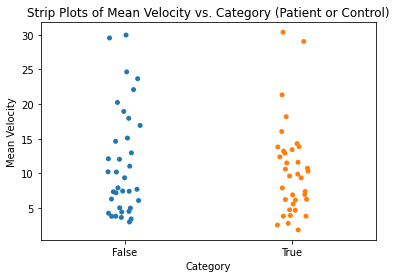

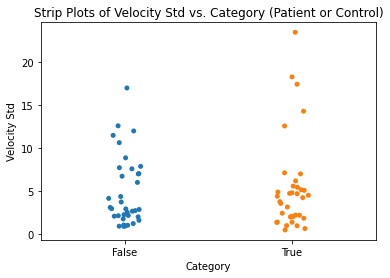

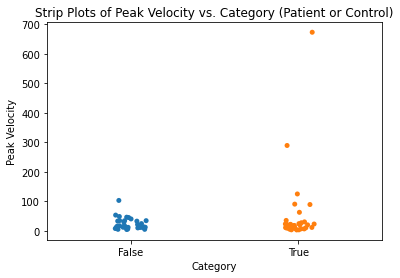

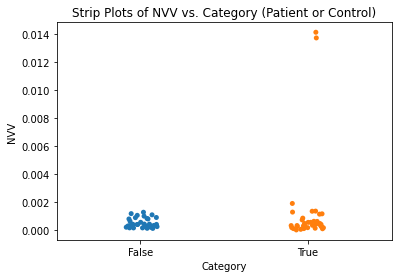

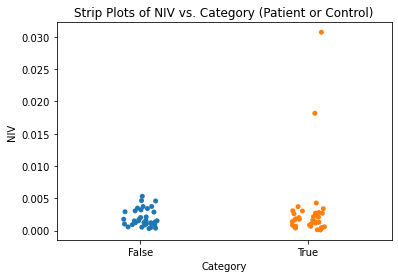

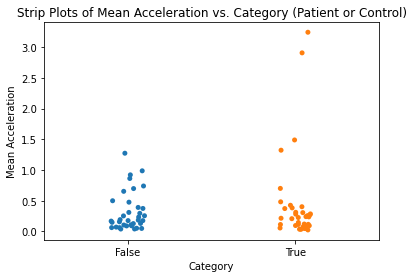

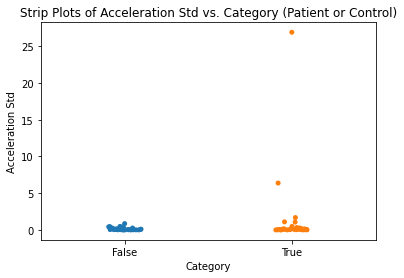

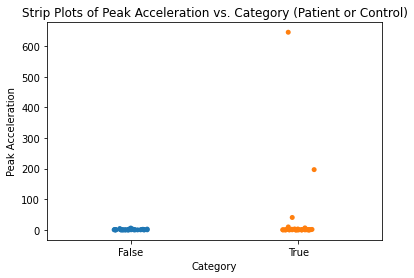

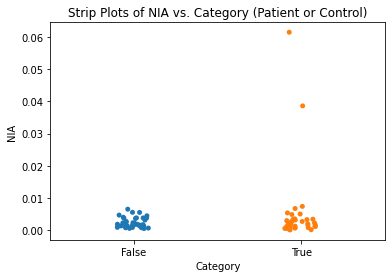

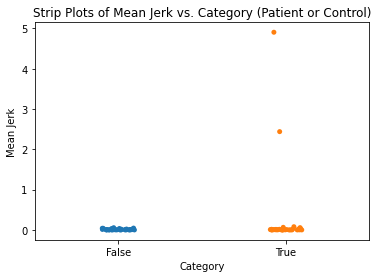

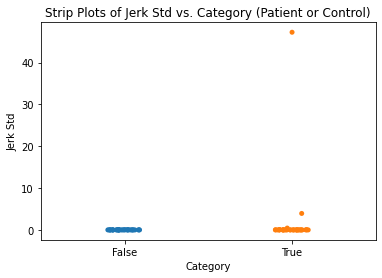

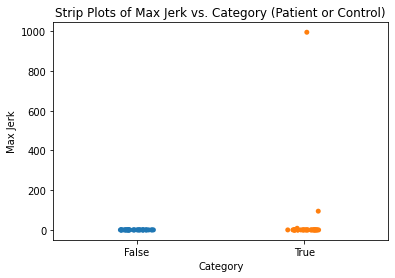

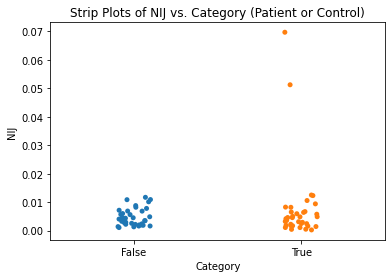

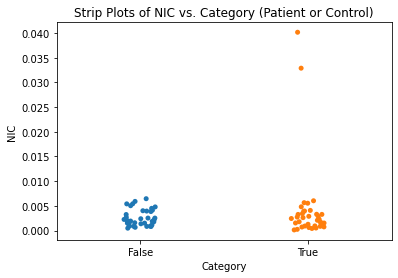

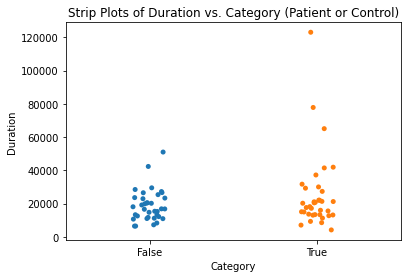

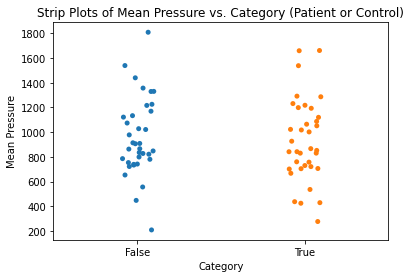

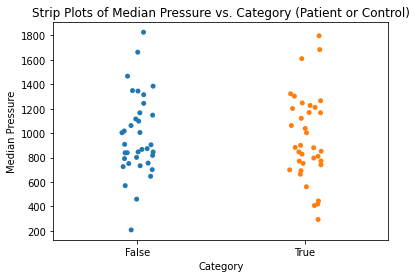

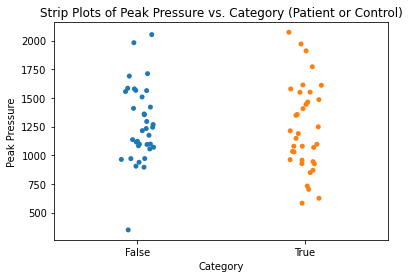

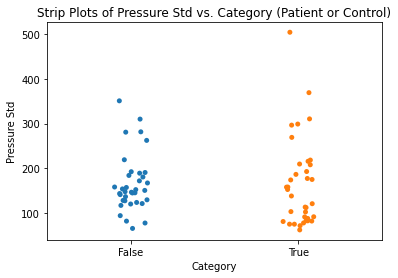

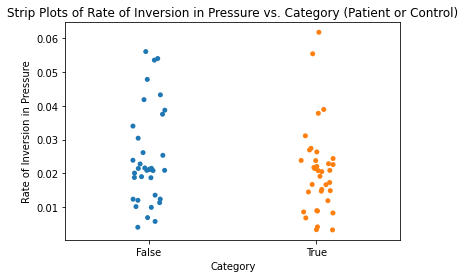

In [ ]:
for i in features_df_static.columns[1:-1]: 
    plt.figure()
    plt.title('Strip Plots of {} vs. Category (Patient or Control)'.format(i))
    sns.stripplot(x = features_df_static['Category'], y = features_df_static[i])

## Logistic Regression

['Mean Pressure' 'Median Pressure' 'Peak Pressure' 'Pressure Std'
 'Rate of Inversion in Pressure']
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False False False  True  True  True False False False  True
  True  True False False False  True  True  True False False False False
 False False False False False False  True  True False  True  True False
 False False False False False False False False False False False  True]


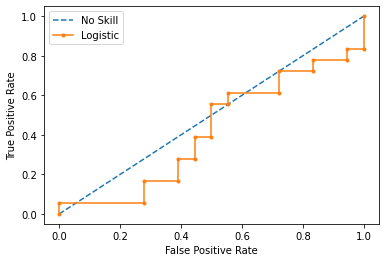

In [ ]:
# 1. import
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import roc_curve

# 2. instantiate model
feature_cols = features_df_static.columns[-6:-1].values
print (feature_cols)
X = features_df_static.loc[:, feature_cols].values
y = features_df_static.Category.values
print (y)

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=10)

logreg = LogisticRegression(solver='lbfgs', max_iter = 12000000)

# 3. fit 
logreg.fit(trainX, trainy)

pred_class = logreg.predict(testX)
pred_probs = logreg.predict_proba(testX)
pred_probs = pred_probs[:, 1]

# 4. calculate scores

# generate a no skill prediction (majority class)
random_probs = [0.5 for _ in range(len(testy))]

random_auc = roc_auc_score(testy, random_probs)
model_log_auc = roc_auc_score(testy, pred_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, random_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, pred_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

In [ ]:
model_log_auc

0.4166666666666667

## Support Vector Classifier

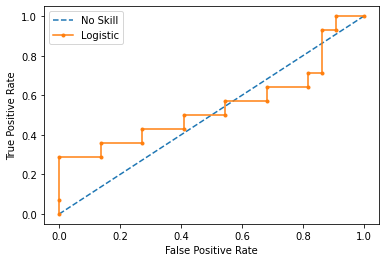

In [ ]:
from sklearn.svm import SVC

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=1)

svclassifier = SVC(kernel='linear', probability = True)

svclassifier.fit(trainX, trainy)

pred_class = svclassifier.predict(testX)
pred_probs = svclassifier.predict_proba(testX)
pred_probs = pred_probs[:, 1]


# generate a no skill prediction (majority class)
random_probs = [1 for _ in range(len(testy))]

random_auc = roc_auc_score(testy, random_probs)
model_svc_auc = roc_auc_score(testy, pred_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, random_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, pred_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

In [ ]:
print(model_svc_auc)

0.5454545454545454


[0.05081282 0.06893297 0.06060627 0.0540659  0.04279644 0.04828387
 0.04640046 0.05194277 0.05530361 0.0429079  0.04608529 0.05175537
 0.04146536 0.04180461 0.04984602 0.0364094  0.03940577 0.04418783
 0.07179497 0.05519238]


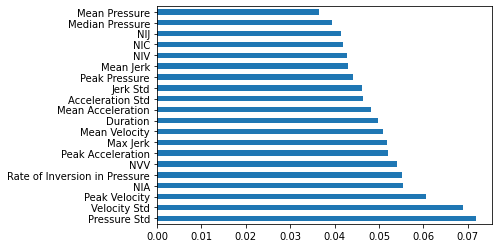

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

feature_cols = features_df_static.columns.values[1:-1]
Xcols = features_df_static.loc[:, feature_cols]
ycols = features_df_static.Category

model = ExtraTreesClassifier()
model.fit(Xcols,ycols)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=Xcols.columns)
#print(feat_importances)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=54ea7590-1f30-42ee-b9c1-c929b94e3f2f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>